In [1]:
#By Eden, Ryan, Michael, Vishnu

In [2]:
from camera import take_picture
import pickle
from dlib_models import download_model, download_predictor, load_dlib_models
from dlib_models import models
# first, we load the models that dlib has to detect faces.
load_dlib_models()
face_detect = models["face detect"]
face_rec_model = models["face rec"]
shape_predictor = models["shape predict"]

In [3]:
def capture_image(port):
    """
    Takes in the desired port for image capture on the machine and returns (1) an RGB image array of shape (H,W,3)
    and (2) a list of descriptors which map to faces detected in the image.
    
    Parameters: 
    port: an integer that calls a specific port on the laptop depending on where the image is being taken
    
    Returns:
    img_array: a (H,W,3) array of image data
    descriptors: a list of (128,) descriptors of faces from img_array.
    detections: a list of dlib.rectangles with the coordinates of each face in the img_array
    
    """
    
    # first configure the camera
#     %matplotlib notebook
#     from camera import test_camera
#     fig, ax, img = test_camera(port=port, exposure=.3)

    # save that configuration
#     from camera import save_camera_config
#     save_camera_config(port=port, exposure=0.2)

    # get the (H,W,3) array of image data
    %matplotlib notebook
    from camera import take_picture
    import matplotlib.pyplot as plt
    img_array = take_picture()
    
    # get the (128,) image descriptor array
    import numpy as np
    
    # download the models from dlib
    from dlib_models import download_model, download_predictor, load_dlib_models

    from dlib_models import models
   
    # load the models that dlib has to detect faces.
    load_dlib_models()
    face_detect = models["face detect"]
    face_rec_model = models["face rec"]
    shape_predictor = models["shape predict"]
    
    # Take in the (H,W,3) img_array and return the number of face detections in the photo
    detections = list(face_detect(img_array))
    
    # for each detected face, create a descriptor
    descriptors = []
    for image in range(len(detections)):
        shape = shape_predictor(img_array, detections[image])
        descriptor = np.array(face_rec_model.compute_face_descriptor(img_array, shape))
        descriptors.append(descriptor)
        
    return img_array, descriptors, detections

################################################################################################################################

def imported_image(file_path):
    """
    Parameters:
        file_path: a file_path to an image that can be detected
        
    Returns:
        img_array: a (H,W,3) image array which prints the image from the filepath
        descriptors: a (128,) array descriptor
        detections: a list of dlib.rectangle objects
    """
    import PIL.Image
    img_array = PIL.Image.open(file_path)
    
    import numpy as np
    img_array = np.array(img_array)
    
    # download the models from dlib
    from dlib_models import download_model, download_predictor, load_dlib_models
#     download_model()
#     download_predictor()
    from dlib_models import models
    
#     # load the models that dlib has to detect faces.
#     load_dlib_models()
    face_detect = models["face detect"]
    face_rec_model = models["face rec"]
    shape_predictor = models["shape predict"]
    
    # Take in the (H,W,3) img_array and return the number of face detections in the photo
    detections = list(face_detect(img_array))
    
    # for each detected face, create a descriptor
    descriptors = []
    for image in range(len(detections)):
        shape = shape_predictor(img_array, detections[image])
        descriptor = np.array(face_rec_model.compute_face_descriptor(img_array, shape))
        descriptors.append(descriptor)
        
    return img_array, descriptors, detections

################################################################################################################################

def print_faces(img_array, detections):
    """
    Parameters:
        img_array: a (H,W,3) array of image data
        detections: a list of dlib.rectangle objects
    """
    import matplotlib.pyplot as plt
    if(type(detections) != list):
        detections = list(detections)
        
        
    if len(detections) == 1:
        rect = detections[0]
        fig,ax = plt.subplots()
        x1,x2,y1,y2 = rect.left(), rect.right(), rect.top(), rect.bottom()
        ax.imshow(img_array[y1:y2,x1:x2,:])

    
    else:
        fig,ax = plt.subplots(ncols = len(detections))
        # https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
        for i, rect in enumerate(detections):
            x1,x2,y1,y2 = rect.left(), rect.right(), rect.top(), rect.bottom()
            ax[i].imshow(img_array[y1:y2,x1:x2,:])
            ax[i].axis('off')

################################################################################################################################

def import_pickle():
    """
    Returns:
    faces: a dictionary with key, value of face and associated descriptors.
    """
    faces={}
    with open("faces.pkl", mode="rb") as opened_file:
        faces=pickle.load(opened_file)
    return faces

################################################################################################################################

def pickle_the_pickle(faces_dictionary):
    """
    Takes in a dictionary of face labels and associated descriptors and populates a pickle.
    
    Parameters:
    faces_dictionary: a dictionary where key, value is face label, associated descriptors
    """
    with open("faces.pkl", mode="wb") as opened_file:
        pickle.dump(faces_dictionary, opened_file)
    print("The Pickle has been pickled")
    
################################################################################################################################

def log_into_database(descriptor,name):
    """
    Parameters:
        descriptor: a (128,) array that describes the img_array input
        name: the name associated with the descriptor
    """
    
    #assert len(descriptor) == 128
    faces = import_pickle()
    if name in faces.keys():
        faces[name].append(descriptor)
    else:
        faces.update([(name,descriptor)])
    pickle_the_pickle(faces)
    
################################################################################################################################

def search(descriptor):
    """
    Finds probable labels for whatever descriptors are input.
    Parameters:
        descriptor: an array of (128,) to describe a person
    Returns:
        probable_faces: a list of probable names to describe the descriptor
    """
    import numpy as np
    faces = import_pickle()
    distances = []
    
    for name in list(faces.keys()):
        mean = np.mean(faces[name],axis=0) # takes elementwise mean
        distances.append(euclidean_distance(mean,descriptor))
    
    print(distances)
    # populate a list with probable names within the threshold
    probable_faces = []
    threshold = .4
    for i, distance in enumerate(distances):
        if distance < threshold:
            probable_faces.append(list(faces.keys())[i])
    
    # todo: figure out the threshold value. will we be able to return just one?
    if probable_faces == []:
        probable_faces.append("idk lol")
    return probable_faces[0]
        
################################################################################################################################

def rect_coordinates(rect):
    """
    Takes a dlib.rectangle object and pulls the x1,x2,y1,y2 coordinates
    which maps to the rectangle.
    Parameters:
        rect: a dlib.rectangle object
        
    Returns:
        x1,y1,x2,y2: a list of coordinates which will map to a space on an image
    """
    x1,y1,x2,y2 = rect.left(), rect.right(), rect.top(), rect.bottom()
    
    return x1,y1,x2,y2

################################################################################################################################

def euclidean_distance(arr1,arr2):
    """
    Returns the euclidean distance between two matrices.
    """
    import numpy as np
    distance = np.sqrt(np.sum((arr1 - arr2)**2))
    return distance

################################################################################################################################

# run this cell to setup matplotlib, and also import the very important take_picture function from camera!
def getRect(pic,detection, names):
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from camera import take_picture
    import numpy as np

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    # run this cell to download the models from dlib
    from dlib_models import download_model, download_predictor, load_dlib_models
#    download_model()
 #   download_predictor()
    from dlib_models import models
    # first, we load the models that dlib has to detect faces.
    load_dlib_models()
    face_detect = models["face detect"]
    face_rec_model = models["face rec"]
    shape_predictor = models["shape predict"]
    
    # Create figure and axes
    fig,ax = plt.subplots()

    # Display the image
    ax.imshow(pic)

    # Create a Rectangle patch
    #detection = list(face_detect(pic))
    for val in range(len(detection)):
        det = detection[val]

        l, r, t, b = det.left(), det.right(), det.top(), det.bottom()  
        rect = patches.Rectangle((l,t),r-l,b-t,linewidth=1,edgecolor='y',facecolor='none',label='label')
        plt.text(l, t-2,names[val],color='yellow')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

################################################################################################################################
def compute_distances(x, y):
    """ Write a function that computes the L2 distance between each row
        in `x` and `y`.
        Parameters
        ----------
        x : numpy.ndarray
            x.shape must be (M, D)
            Each row of `x` is a flattened vector representing the pixel
            values of a single image. Thus `x` represents
            M images, each one described by a length-D vector.
        y : numpy.ndarray
            y.shape must be (N, D)
            Each row of `y` is a flattened vector representing the pixel
            values of a single image. Thus `y` represents
            N images, each one described by a length-D vector.
        Returns
        -------
        distances : numpy.ndarray
            distances.shape = (M, N)
            distances[i, j] = the L2 distance between x[i] and y[j]
        knot ritten bai rian
    """
    # STUDENT CODE GOES HERE
    dists = -2 * np.dot(x, y.T)
    dists +=  np.sum(x**2, axis=1)[:, np.newaxis]
    dists += np.sum(y**2, axis=1)
    return  np.sqrt(dists)
################################################################################################################################

def cluster_prep(*inputs):
    #Issue to discuss with group/ if it cannot figure out pieces of the image, it will just not go till there DISCUSS
    images = inputs[0]
    Descriptors = np.zeros((len(images)-1)*128).reshape(-1,128)
    print(Descriptors.shape)
    for image in range(len(images)-1):
        img_array, descriptors, detections = imported_image(images[image])
        ####Working here
        print(image)
        for number in range(128):
            print(len(descriptors[0]))
            Descriptors[image,number] = descriptors[0][number]
       # for val in range(128):
        #    counter = counter + 1
            #print(counter)
            #print(len(descriptors[0]))
         #   Descriptors[image,val] = descriptors[0][val]
       # shape = shape_predictor(images[image], list(face_detect(img_array)))
        #descriptors[image] = np.array(face_rec_model.compute_face_descriptor(img_array, shape))
       # print(counter)
    print(Descriptors)
    return Descriptors
    
################################################################################################################################

#picture_list = np.array([[1,2,3,4,5,6,7,8,9],[9,8,7,6,3,4,3,2,1],[1.35,2,3,4,5,6,7,8,9]])#numbers used in unit testing
def Cluster(pic_list):
    """This function takes in an array of descriptors (numpy arrays)
       of unlabeled images and puts them in their correct group.
       Parameters
       ----------
       pic_list : numpy.ndarray
                  pic_list.shape must be (number of pictures, 128)
                  Each row of pic_list is a separate picture. Each
                  of those is the descriptor for an image.
       Returns
       -------
       clusters : numpy.ndarray
       
    """
    weightArray = compute_distances(pic_list,pic_list) #This function is from python like you mean it, the best source for python knowledge
    weightArray[weightArray==0] = 100 #Prevents the diagonal line of 0s from affecting the function
    weightArray = np.reciprocal(weightArray*weightArray) #Does the 1/d^2 thing to find the weights. See the lecture notes if this confuses you.
    weightArray[weightArray<1/thresh**2]=-1 #Filters out distances greater than the threshold.
    weightArray[weightArray != weightArray] = -1 #takes out those nans
    labelList = np.arange(0,pic_list.shape[0]) #List of the labels
    #Does a weighted node check. See lecture notes.
    for i in range(1000):
        temp = np.random.randint(0,len(labelList))
        if(weightArray[temp][np.argmax(weightArray[temp])]>0):
            labelList[temp] = labelList[np.argmax(weightArray[temp])]
    cluster = []
    usedLabels = []
    #Groups indexes of the images with those in their cluster
    for i in range(len(labelList)):
        if(labelList[i] in usedLabels):
            cluster[usedLabels.index(labelList[i])].append(i)
        else:
            usedLabels.append(labelList[i])
            cluster.append([i])
    return cluster
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################

In [4]:
"""This cell has stuff that is going to be the input and the threshold hyper parameter. We wont need this cell in the
    final product but thresh=.4 must be carried over
"""
#Michael Heege
%matplotlib notebook
import matplotlib.pyplot as plt
from camera import take_picture
import numpy as np
import math
numPics = 30 #This is just a random number lol

#picture_list = np.random.rand(numPics,128)
picture_list = np.array([
    [-1.41850531e-01,  1.43561035e-01,  5.08363172e-02, -8.64651054e-02, -5.48480861e-02, -2.28612311e-02, -4.01193649e-02, -8.03256482e-02, 9.87884253e-02, -4.93800417e-02,  2.55014151e-01,  1.26997102e-02, -2.75324374e-01,  2.69229803e-02, -6.11235388e-02,  1.61960706e-01, -2.27753058e-01, -1.16207346e-01, -1.10878989e-01, -1.17769055e-01,2.79660933e-02,  1.05828576e-01, -7.66103491e-02,  7.25992396e-02,-6.55399859e-02, -2.51942754e-01, -2.66701281e-02, -4.77677807e-02,5.71409687e-02, -8.40669498e-02,  1.00152664e-01,  3.71634029e-02,-1.00466214e-01,  1.99006870e-04,  1.09313339e-01,  7.80157447e-02,-5.05675860e-02, -6.09365292e-04,  2.51595140e-01,  6.98729306e-02,-1.41452804e-01,  5.75262383e-02,  1.06946662e-01,  3.55832964e-01,1.59973443e-01,  9.17222723e-02, -1.86552592e-02, -1.04875699e-01,1.05024286e-01, -2.61727482e-01,  2.95976307e-02,  2.29577795e-01,1.19689897e-01,  1.39422730e-01,  5.31536303e-02, -2.19712660e-01,-2.22930610e-02,  1.54278070e-01, -2.08627686e-01,  7.96065181e-02,3.62448245e-02, -6.22425042e-02,  3.40752974e-02, -1.04356870e-01,2.15179414e-01,  6.25364035e-02, -2.31357217e-01, -1.03472546e-01,1.20753206e-01, -1.51922464e-01, -1.55901402e-01,  6.21888638e-02,-1.23896331e-01, -1.37908071e-01, -2.90778846e-01,  5.11730015e-02,3.46391410e-01,  1.12319775e-01, -1.64382055e-01, -6.12329133e-02,1.30630727e-03, -9.47362781e-02,  9.67717916e-03,  1.13279708e-01,-1.18458062e-01, -1.06335089e-01,  2.39871237e-02, -1.81101318e-02,1.86337069e-01,  6.98890984e-02, -4.71582301e-02,  2.05844894e-01,5.94484527e-03,  2.27240231e-02, -3.08575593e-02,  9.11375582e-02,-1.22524783e-01, -6.86994344e-02, -1.34142324e-01, -5.24125807e-02,-1.06906682e-01, -7.05469176e-02,  2.78171226e-02,  1.53697714e-01,-1.83008835e-01,  1.95409641e-01,  7.40365591e-04, -2.60274895e-02,-7.63704553e-02,  1.15093723e-01, -8.73314664e-02, -7.13973818e-03,1.85926095e-01, -2.25677863e-01,  2.89313912e-01,  2.60544628e-01,9.00219679e-02,  6.94745108e-02,  9.55998003e-02,  1.20044444e-02,-9.19830985e-03,  1.11695901e-02, -1.23886019e-01, -1.24676712e-01,1.47075672e-02, -7.42842779e-02,  6.96285516e-02, -3.74712469e-03],
    [-0.13345364,  0.17177933,  0.04407747, -0.06411494, -0.05136455, -0.03796488,-0.03501369, -0.08582252,  0.09174997, -0.03670132,  0.22597823,  0.01154747,-0.2518132,   0.05156056, -0.05707371,  0.13329166, -0.24473259, -0.10264518,-0.11022684, -0.10775107,  0.03900959,  0.11738839, -0.09119581,  0.05472872,-0.08483306, -0.25498691, -0.04225614, -0.0317883,   0.07765634, -0.03415798,0.08645369,  0.04142179, -0.08708452, -0.00364224,  0.11097603,  0.03918492,-0.05706827,  0.00517862,  0.26194444,  0.06354892, -0.16253589,  0.07548124,0.11678885,  0.35378438,  0.16533427,  0.10388403, -0.00509007, -0.08708938,0.12163203, -0.26344863,  0.02666206,  0.22226322,  0.13523811,  0.14247832,0.02720681, -0.24773502, -0.04492596,  0.13420132, -0.19511271,  0.07878923,0.04368557, -0.09440516,  0.04376904, -0.08602973,  0.20730346,  0.06608352,-0.21347758, -0.09851978,  0.13328934, -0.15557916, -0.13296065,  0.06200052,-0.10520262, -0.14258167, -0.27784359,  0.06261133,  0.34882864,  0.1224038,-0.13392018, -0.05801519, -0.00218363, -0.0733205,   0.01496164,  0.09745319,-0.1620122, -0.08756541,  0.01026226, -0.00463573, 0.2248648,   0.0602124,-0.06397311,  0.21101189,  0.02362038,  0.05214758, -0.02656687,  0.07885991,-0.12075713, -0.07546131, -0.13346693, -0.02639033, -0.06663679, -0.07164879,0.03821329,  0.17008184, -0.18353772,  0.21835105, -0.00059669, -0.01351773,-0.0863006,   0.10287383, -0.0826799,   0.01946557,  0.18714444, -0.1941226,0.28489789,  0.23243083,  0.09618647,  0.09363035,  0.11102139, -0.02309525,-0.01133752, -0.00108673, -0.13746031, -0.12899783,  0.05189463, -0.07806993,0.1015846,   0.00858686],
    [-0.09222962, -0.00738695,  0.03495588, -0.09783944, -0.0109241,   0.03729647,-0.02322386, -0.14097582,  0.20430531, -0.18807513,  0.17929541,  0.0159448,-0.21434753, -0.08501723, -0.00677306,  0.04076761, -0.14802894, -0.21224564,-0.04340013, -0.04997475, -0.05011522, -0.04914607,  0.01025447, 0.05281912,-0.16406068, -0.3921296,  -0.14479958, -0.0960599,   0.07712621, -0.0100166,-0.02335356,  0.05962497, -0.24308908, -0.01858897, -0.0076916,   0.08670165,0.03573158,  0.01397519,  0.21012592,  0.06712442, -0.19643234, -0.0538009,0.01493275,  0.2009961,   0.11970054,  0.05371275,  0.00278445, -0.08656369,0.05707875, -0.20058309,  0.1289362,   0.17791665,  0.10845801,  0.0331062,0.06927906, -0.15825944, -0.01574098,  0.07625427, -0.19827104,  0.12165718,0.01035189, -0.04659954, -0.03799384, -0.0225189,   0.20266004,  0.15244269,-0.09953566, -0.15739137,  0.26300478, -0.17744227,  0.01292379,  0.07972659,-0.0491488,  -0.17723462, -0.21389742,  0.05497315,  0.41961315,  0.19067362,-0.13172925,  0.0530475,  -0.15608454, -0.13192053,  0.05748538,  0.06494732,-0.10737799,  0.05525945,  0.00283242,  0.04893204,  0.18391338,  0.11642427,-0.02476422,  0.21567933, -0.06343228,  0.07722367,  0.06818441,  0.0390949,-0.10803303,  0.00872496, -0.15745531, -0.02718439,  0.01420276, -0.06301925,0.0515933,  0.10460018, -0.17253394,  0.13441654,  0.0045562,  -0.08253068,0.05174553,  0.09628704, -0.10995986, -0.09784915,  0.15812179, -0.31974611,0.18398681,  0.14986338,  0.05507609,  0.15729207,  0.11012201,  0.07081494,0.04885063, -0.08597775, -0.17803672, -0.05564306,  0.03011209, -0.09206554,0.0663693,   0.03734079]
])
#the picture_list is currently [Picture of Michael, Different Picture of Michael, Picture of Vishnu]
#number of pictures, 128 for each descriptor

thresh = .4 #If the distance is greater than this they are unrelated

In [4]:
def final_func(func, port = 0,name = "",pictures = [],path = "",clustery = False):
    
    if(clustery == False):
        """
        Parameters:
            func: One of several functions
                imgcapture_log: logs photos into the database through camera
                    REQUIRED PARAMETERS:: name
                imgcapture_search: searches through images based on a camera input
                    REQUIRED PARAMETERS:: none
                imgfile_log: logs photos based on file input
                    REQUIRED PARAMETERS:: path, name
                imgfile_search:
                    REQUIRED PARAMETERS: path
            port: the port by which your computer's camera takes image input
            path: in the directory of pics/ , each person has their own folder by their own name with pictures of them
        """
        import os

        full_path = "pics/" + path
        imgs = []

        if func == "imgfile_log":
            # iterate through the names of contents of the folder
            # image_path is name of file in directory; full_path is the path to the folder of a specific person
            for image_path in os.listdir(full_path):
                    input_path = os.path.join(full_path,image_path)
                    imgs.append(input_path)
            # if there are images in the path and we recieve a name, we are LOGGING IN DATABASE
            if ((len(imgs) != 0) & (name != "")):
                for picture in imgs:
                    img_array, descriptors, detections = imported_image(picture)
                    if (descriptors == []):
                        continue
                    print_faces(img_array,detections)
                    log_into_database(descriptors,path)

        elif func == "imgfile_search":
            # this is the SEARCH FUNCTION - a name is not given but we recieve a photo
            # iterate through the names of contents of the folder
            # image_path is name of file in directory; full_path is the path to the folder of a specific person
            for image_path in os.listdir(full_path):
                    input_path = os.path.join(full_path,image_path)
                    imgs.append(input_path)
            for picture in imgs:
                # assuming pictures is a list of 1, we will still have to index into it
                img_array, descriptors, detections = imported_image(picture)
                print_faces(img_array,detections)
                names = []
                for descriptor in descriptors:
                    name = search(descriptor)
                    names.append(name)
            getRect(img_array,detections,names)
                    

        elif func == "imgcapture_log":
            # we do not recieve a photo but we recieve a name - we are LOGGING THROUGH IMAGE CAPTURE
            if (len(pictures) == 0) & (name != ""):
                img_array, descriptors, detections = capture_image(port)
                if (descriptors == []):
                    pass
                print_faces(img_array,detections)
                log_into_database(descriptors,name)        

        elif func == "imgcapture_search":
            img_array, descriptors, detections = capture_image(port)
            if (descriptors == []):
                print("We don't see you")
                pass
            print_faces(img_array,detections) 
            names = []
            for descriptor in descriptors:
                name = search(descriptor)
                names.append(name)
            getRect(img_array,detections,names)
            
        
    else:
        import os
        # run this cell to download the models from dlib
        
            
        full_path = "pics/" + path
        imgs = []

        # iterate through the names of contents of the folder
        # image_path is name of file in directory; full_path is the path to the folder of a specific person
        for image_path in os.listdir(full_path):
                input_path = os.path.join(full_path,image_path)
                imgs.append(input_path)
        descs = cluster_prep(imgs)        
        returning = Cluster(descs)
        return returning
        

<IPython.core.display.Javascript object>


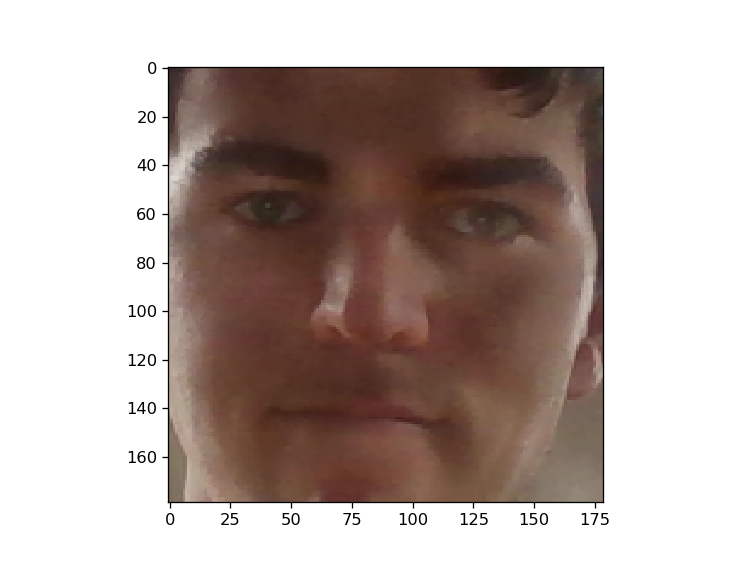

The Pickle has been pickled


In [9]:
final_func("imgcapture_log", name= "Ryan")